# Evalutation results for DBpedia

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def plot_macro_f1(languages: set, f1_scores: dict, x_distance, figsize):
    x = np.arange(len(languages)) * x_distance  # the label locations
    width = 0.4  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained', figsize=figsize)

    for attribute, measurement in f1_scores.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, fmt='%.2f')
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('F1 Score')
    ax.set_title('F1 Scores by languages')
    ax.set_xticks(x + width*(len(f1_scores)-1)/2, languages)
    ax.legend(loc='upper left', ncols=3)
    plt.show()


def get_lang_set(results):
    languages_list = [set(result["Language"].tolist())
                      for result in results.values()]
    return set().union(*languages_list)


def get_f1_scores(results, languages):
    f1_scores = {}
    for name, result_df in results.items():
        scores = list()
        for lang in languages:
            try:
                macro_f1 = result_df.loc[result_df["Language"]
                                         == lang, "Macro F1"].iloc[0]
            except:
                macro_f1 = 0
            scores.append(macro_f1)
        f1_scores[name] = scores
    return f1_scores

def plot(results, x_distance=1, figsize=(8, 8)):
    languages = get_lang_set(results)
    f1_scores = get_f1_scores(results, languages)
    plot_macro_f1(languages, f1_scores, x_distance, figsize)

## Previous results

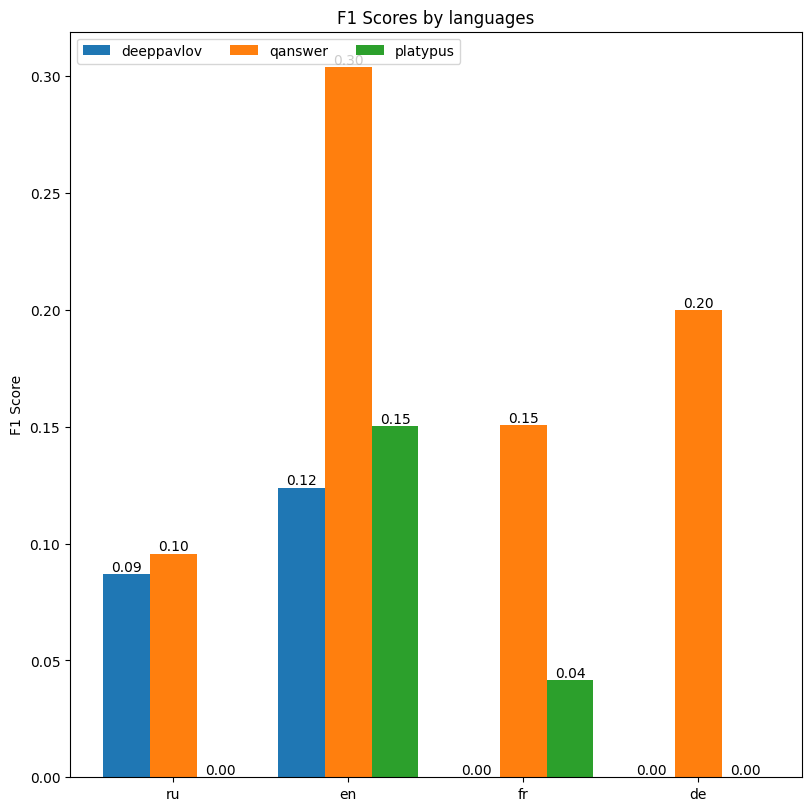

In [4]:
deeppavlov = pd.read_csv("../previous_paper_results/DeepPavlov_dbpedia.csv")
qanswer = pd.read_csv("../previous_paper_results/QAnswer_dbpedia.csv")
platypus = pd.read_csv("../previous_paper_results/Platypus_dbpedia.csv")
plot({
    "deeppavlov": deeppavlov,
    "qanswer": qanswer,
    "platypus": platypus
}, x_distance=1.5)

## Baseline

First, we only fine-tuned mT5-base model on qald-9-plus with DBpedia SPARQLs for 100 epochs as our baseline. 

In [5]:
# https://gerbil-qa.aksw.org/gerbil/experiment?id=202306270001
baseline = pd.read_csv("../gerbil_results/mt5-base-qald9-dbpedia.csv")
baseline

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0633,0.1472,0.0404,0.2901,0.2930,0.2997,0.4436
1,be,0.1366,0.3255,0.0864,0.3670,0.3652,0.3813,0.5045
2,de,0.0439,0.0288,0.0922,0.3727,0.3709,0.3887,0.5183
3,en,0.0313,0.0204,0.0680,0.3352,0.3333,0.3534,0.4864
4,fr,0.0345,0.4423,0.0180,0.2558,0.2564,0.2553,0.4036
5,lt,0.0390,0.0255,0.0831,0.3435,0.3419,0.3600,0.5007
6,ru,0.0336,0.0221,0.0700,0.3484,0.3465,0.3697,0.5043
7,uk,0.0695,0.0641,0.0760,0.3748,0.3725,0.3935,0.5244


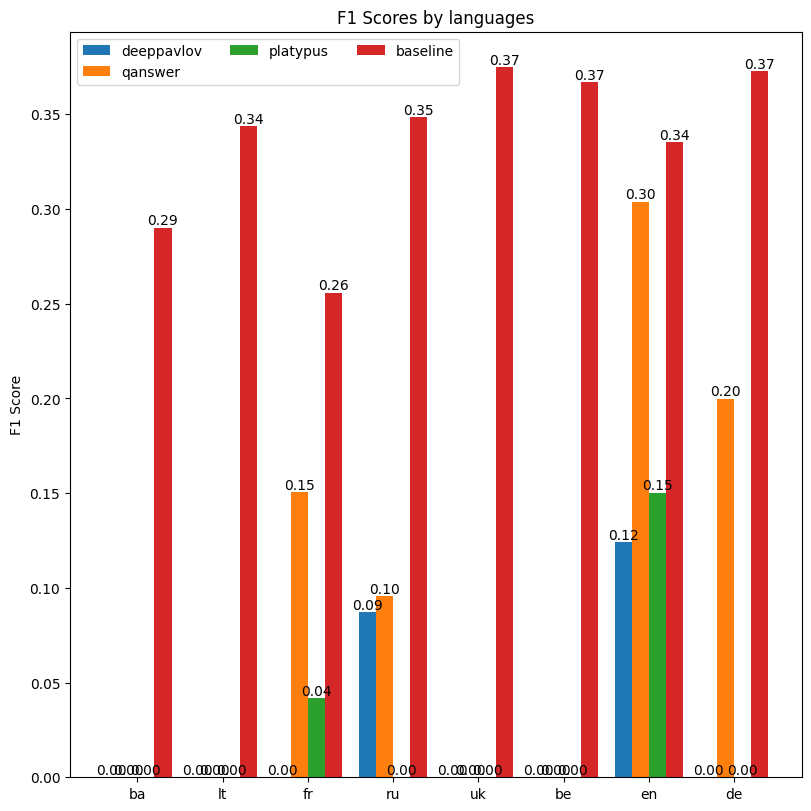

In [6]:
plot({
    "deeppavlov": deeppavlov,
    "qanswer": qanswer,
    "platypus": platypus,
    "baseline": baseline
}, x_distance=2)

## Experiment 10

According to the experience from experiment for Wikidata, we first pre-trained on LCquad 1.0 (about 4000 samples) and fine-tuned on qald-9-plus with all language questions DBpedia SPARQLs.

Since our entity linking tool for DBpedia only works for `en`, `de`, and `fr`, we only evaluated our model on these languages. 

In [7]:
# https://gerbil-qa.aksw.org/gerbil/experiment?id=202306300002
exp10 = pd.read_csv("../gerbil_results/mt5-xl-qald-9-plus-dbpedia.csv")
exp10

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,de,0.0139,0.0077,0.0693,0.3531,0.3513,0.3694,0.5165
1,en,0.0469,0.0282,0.1397,0.3813,0.3938,0.3863,0.5211
2,fr,0.0147,0.0118,0.0194,0.2400,0.2400,0.2465,0.3939


Also from the previous experiments, the results could be better when the langauge model is fine-tuned on less langauges. Therefore, we fine-tuned our model again on qald-9-plus with only `en`, `de`, and `fr`, which are supported by our entity linker, and DBpedia SPARQL. 

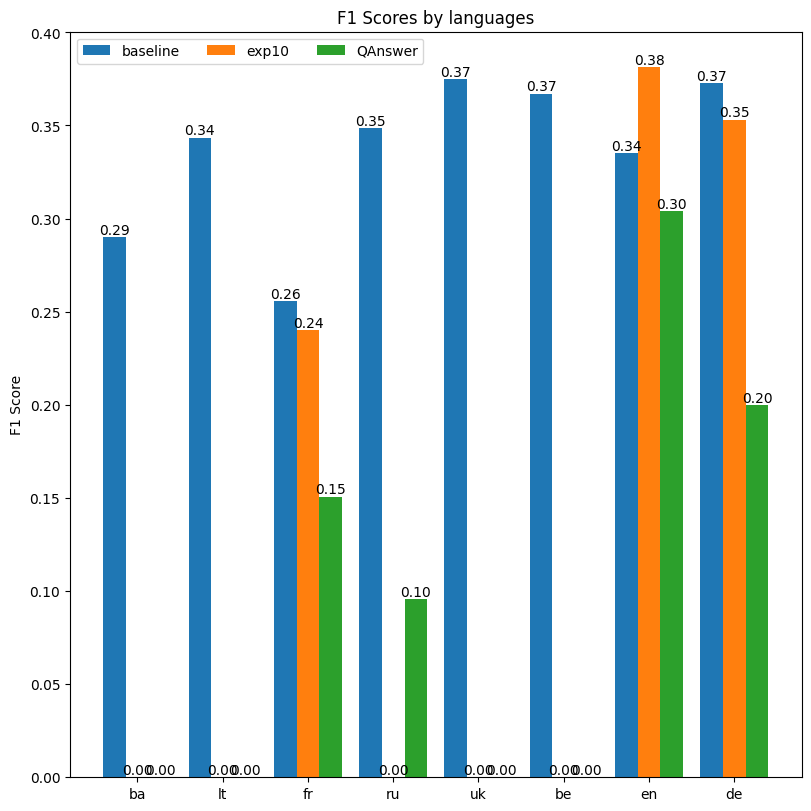

In [8]:
plot({
    "baseline": baseline,
    "exp10": exp10,
    "QAnswer": qanswer
}, x_distance=1.5)

In [9]:
# https://gerbil-qa.aksw.org/gerbil/experiment?id=202307010000
exp10_endefr = pd.read_csv("../gerbil_results/mt5-xl-qald-9-plus-dbpedia-endefr.csv")
exp10_endefr

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,de,0.0102,0.0056,0.0604,0.3726,0.3706,0.3835,0.5234
1,en,0.2262,0.6820,0.1356,0.4249,0.4336,0.4247,0.5597
2,fr,0.0246,0.9783,0.0125,0.2533,0.2533,0.2532,0.4035


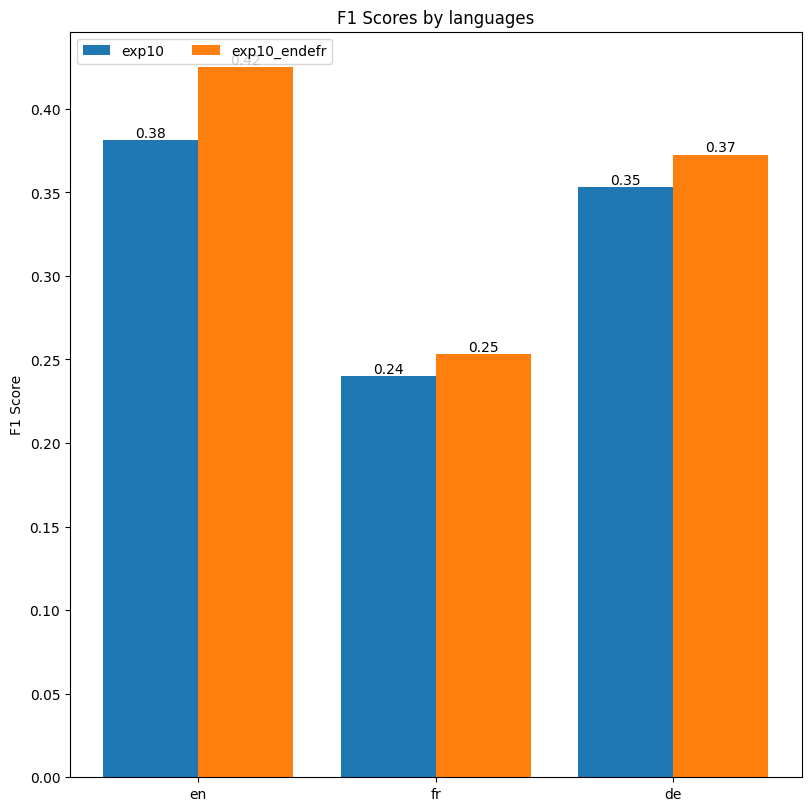

In [10]:
plot({
    "exp10": exp10,
    "exp10_endefr": exp10_endefr
})